## Indendios

## Cobertura del suelo

In [1]:

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
from rasterio.features import rasterize
from io import BytesIO
from owslib.wfs import WebFeatureService

import rioxarray
import contextily as ctx
from shapely.geometry import box
import xarray as xr


USE_CRS = "EPSG:5347"  # posgar para esperanza
WEB_MERCATOR_CRS = "EPSG:3857"

DEFAULT_FIGSIZE = (12, 10)
MAP_PADDING = 500
PLASMA_CMAP = plt.cm.plasma

def setup_base_map(
    figsize=None, bounds=None, boundary_gdf=None, padding_x=None, padding_y=None
):
    """Create figure and set up basic map boundaries with padding."""
    if figsize is None:
        figsize = DEFAULT_FIGSIZE
    if padding_x is None:
        padding_x = MAP_PADDING
    if padding_y is None:
        padding_y = MAP_PADDING

    if bounds is None and boundary_gdf is not None:
        bounds = boundary_gdf.total_bounds

    # Convert bounds to Web Mercator for basemap compatibility
    if bounds is not None:
        # Create a temporary GeoDataFrame with the bounds to reproject
        temp_bounds = gpd.GeoDataFrame(
            geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])], crs=USE_CRS
        )
        bounds_3857 = temp_bounds.to_crs(WEB_MERCATOR_CRS).total_bounds
    else:
        bounds_3857 = bounds

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds_3857[0] - padding_x, bounds_3857[2] + padding_x)
    ax.set_ylim(bounds_3857[1] - padding_y, bounds_3857[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""

    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )

    return ax


def add_north_arrow(ax, x=0.95, y=0.05, arrow_length=0.04):
    """Add a north arrow to the map."""
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(facecolor="black", width=3, headwidth=10),
        ha="center",
        va="center",
        fontsize=14,
        xycoords=ax.transAxes,
    )


def add_boundary_outline(ax, boundary_gdf, crs="EPSG:3857"):
    """Add the outline of a boundary geodataframe to a map."""
    boundary_3857 = boundary_gdf.to_crs(crs)
    boundary_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        linewidth=0.5,
        linestyle="--",
        legend=False,
        zorder=5,
    )


def create_consistent_map(title, boundary_gdf, bounds=None):
    """Create a map with consistent styling and basemap."""
    fig, ax = setup_base_map(bounds=bounds, boundary_gdf=boundary_gdf)

    add_basemap(ax)

    add_north_arrow(ax)

    add_boundary_outline(ax, boundary_gdf)

    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)

    ax.set_axis_off()

    return fig, ax


def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

dptos = wfs_to_gdf(wfs_url=base_url, layer_name="ign:departamento", srs="EPSG:4326")

aoi = dptos[dptos["nam"] == "Río Segundo"]
aoi = aoi.to_crs(USE_CRS)

In [14]:
import rioxarray as rio

# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 1024, "y": 1024},
)

# Clip with from_disk=True for memory efficiency
suelo_2022 = suelo_2022.rio.clip(
    aoi.geometry.values,
    aoi.crs,
    from_disk=True,
)

In [29]:
# Define the detailed categories and colors
categories_detailed = {
    'Leñosa cerrada': {'ids': [3], 'color': '#1f8d49'},
    'Leñosa abierta': {'ids': [4], 'color': '#7dc975'},
    'Leñosa dispersa': {'ids': [45], 'color': '#807a40'},
    'Leñosa inundable': {'ids': [6], 'color': '#026975'},
    'Vegetación no leñosa inundable': {'ids': [11], 'color': '#519799'},
    'Pastizal': {'ids': [12], 'color': '#d6bc74'},
    'Estepa': {'ids': [63], 'color': '#ebf8b5'},
    'Pastura': {'ids': [15], 'color': '#edde8e'},
    'Agricultura': {'ids': [18], 'color': '#e974ed'},
    'Plantación forestal': {'ids': [9], 'color': '#7a5900'},
    'Cultivo arbustivo': {'ids': [36], 'color': '#d082de'},
    'Mosaico agropecuario': {'ids': [21], 'color': '#ffefc3'},
    'Área sin vegetación': {'ids': [22], 'color': '#d4271e'},
    'Río, lago u océano': {'ids': [33], 'color': '#2532e4'},
    'Hielo y nieve en superficie': {'ids': [34], 'color': '#93dfe6'},
    'No observado': {'ids': [27], 'color': '#ffffff'}
}

# You can also create grouped categories for broader analysis
categories_grouped = {
    'Vegetación leñosa': {
        'ids': [3, 4, 45, 6], 
        'color': '#1f8d49',
        'subcategories': ['Leñosa cerrada', 'Leñosa abierta', 'Leñosa dispersa', 'Leñosa inundable']
    },
    'Vegetación no leñosa': {
        'ids': [11, 12, 63], 
        'color': '#d6bc74',
        'subcategories': ['Vegetación no leñosa inundable', 'Pastizal', 'Estepa']
    },
    'Área agropecuaria': {
        'ids': [15, 18, 9, 36, 21], 
        'color': '#ffefc3',
        'subcategories': ['Pastura', 'Agricultura', 'Plantación forestal', 'Cultivo arbustivo', 'Mosaico agropecuario']
    },
    'Área sin vegetación': {
        'ids': [22], 
        'color': '#d4271e',
        'subcategories': ['Área sin vegetación']
    },
    'Cuerpo de agua': {
        'ids': [33, 34], 
        'color': '#2532e3',
        'subcategories': ['Río, lago u océano', 'Hielo y nieve en superficie']
    },
    'No observado': {
        'ids': [27], 
        'color': '#ffffff',
        'subcategories': ['No observado']
    }
}

# Function to categorize pixels
def categorize_pixel_detailed(value, categories):
    """Convert pixel value to detailed category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

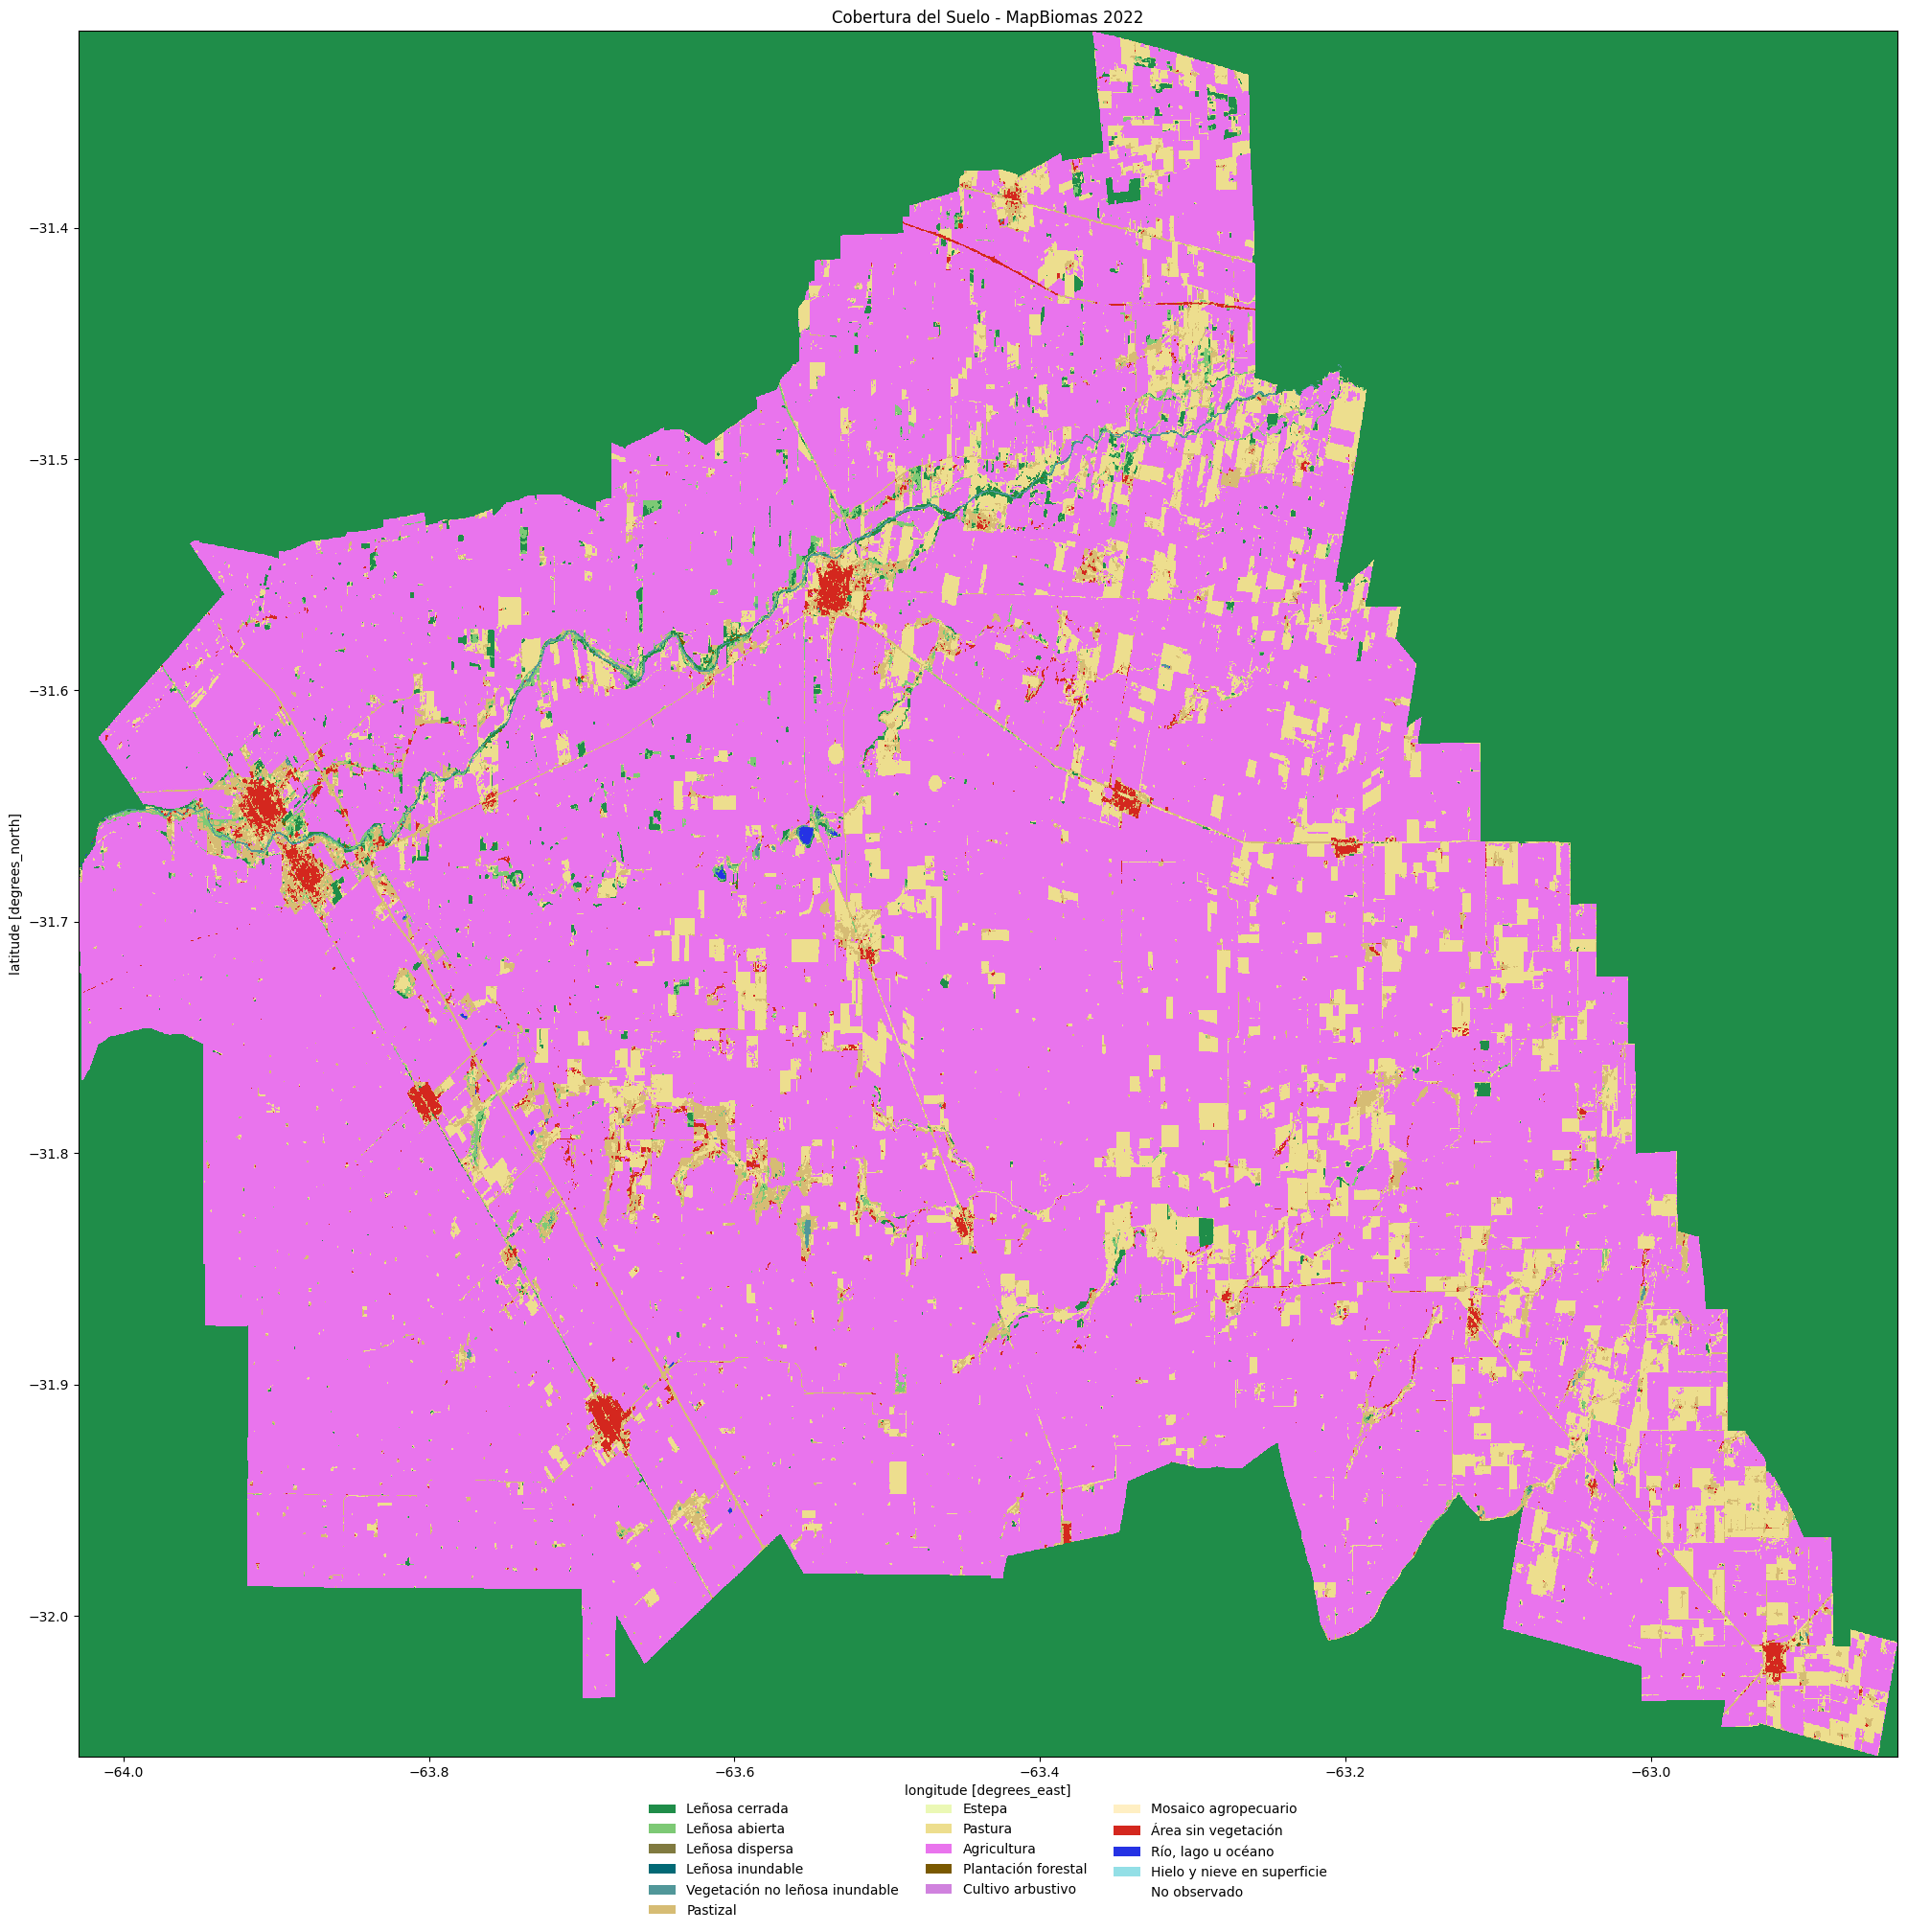

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        colors[pixel_id] = info['color']

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2022.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info['color']] = category

# Add legend below the map
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=label) 
                  for color, label in legend_labels.items()]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
          ncol=3, frameon=False)

plt.title('Cobertura del Suelo - MapBiomas 2022')
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd
import numpy as np

# Calculate pixel counts for each category
unique_values, counts = np.unique(suelo_2022.values[0], return_counts=True)

# Create a mapping from pixel IDs to category names
id_to_category = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        id_to_category[pixel_id] = category

# Calculate total pixels and area per pixel (assuming 100m resolution)
total_pixels = np.sum(counts)
pixel_area_hectares = 0.01  # 100m x 100m = 1 hectare

# Create results list
results = []
for pixel_id, count in zip(unique_values, counts):
    if pixel_id in id_to_category:
        category = id_to_category[pixel_id]
        area_hectares = count * pixel_area_hectares
        percentage = (count / total_pixels) * 100
        results.append({
            'Categoría': category,
            'ID': pixel_id,
            'Área (hectáreas)': f"{area_hectares:,.1f}",
            'Porcentaje (%)': f"{percentage:.1f}"
        })

# Sort by area (descending)
results.sort(key=lambda x: float(x['Área (hectáreas)'].replace(',', '')), reverse=True)

# Create DataFrame and display
df = pd.DataFrame(results)
print("Cobertura del Suelo - MapBiomas 2022")
print("=" * 50)
print(df.to_string(index=False))
print(f"\nTotal área: {total_pixels * pixel_area_hectares:,.1f} hectáreas")

Cobertura del Suelo - MapBiomas 2022
                     Categoría  ID Área (hectáreas) Porcentaje (%)
                   Agricultura  18         56,063.3           45.9
                       Pastura  15          7,213.2            5.9
                      Pastizal  12          2,308.3            1.9
           Área sin vegetación  22            661.9            0.5
                Leñosa cerrada   3            577.9            0.5
                Leñosa abierta   4            529.0            0.4
Vegetación no leñosa inundable  11            135.0            0.1
            Río, lago u océano  33             13.6            0.0
           Plantación forestal   9              7.7            0.0
              Leñosa inundable   6              0.1            0.0
          Mosaico agropecuario  21              0.0            0.0

Total área: 122,273.7 hectáreas


In [11]:
import rioxarray as rio

# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2000_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2000.tif"

suelo_2000 = rio.open_rasterio(
    suelo_2000_ruta,
    chunks={"x": 1024, "y": 1024},
)

# Clip with from_disk=True for memory efficiency
suelo_2000 = suelo_2000.rio.clip(
    aoi.geometry.values,
    aoi.crs,
    from_disk=True,
)

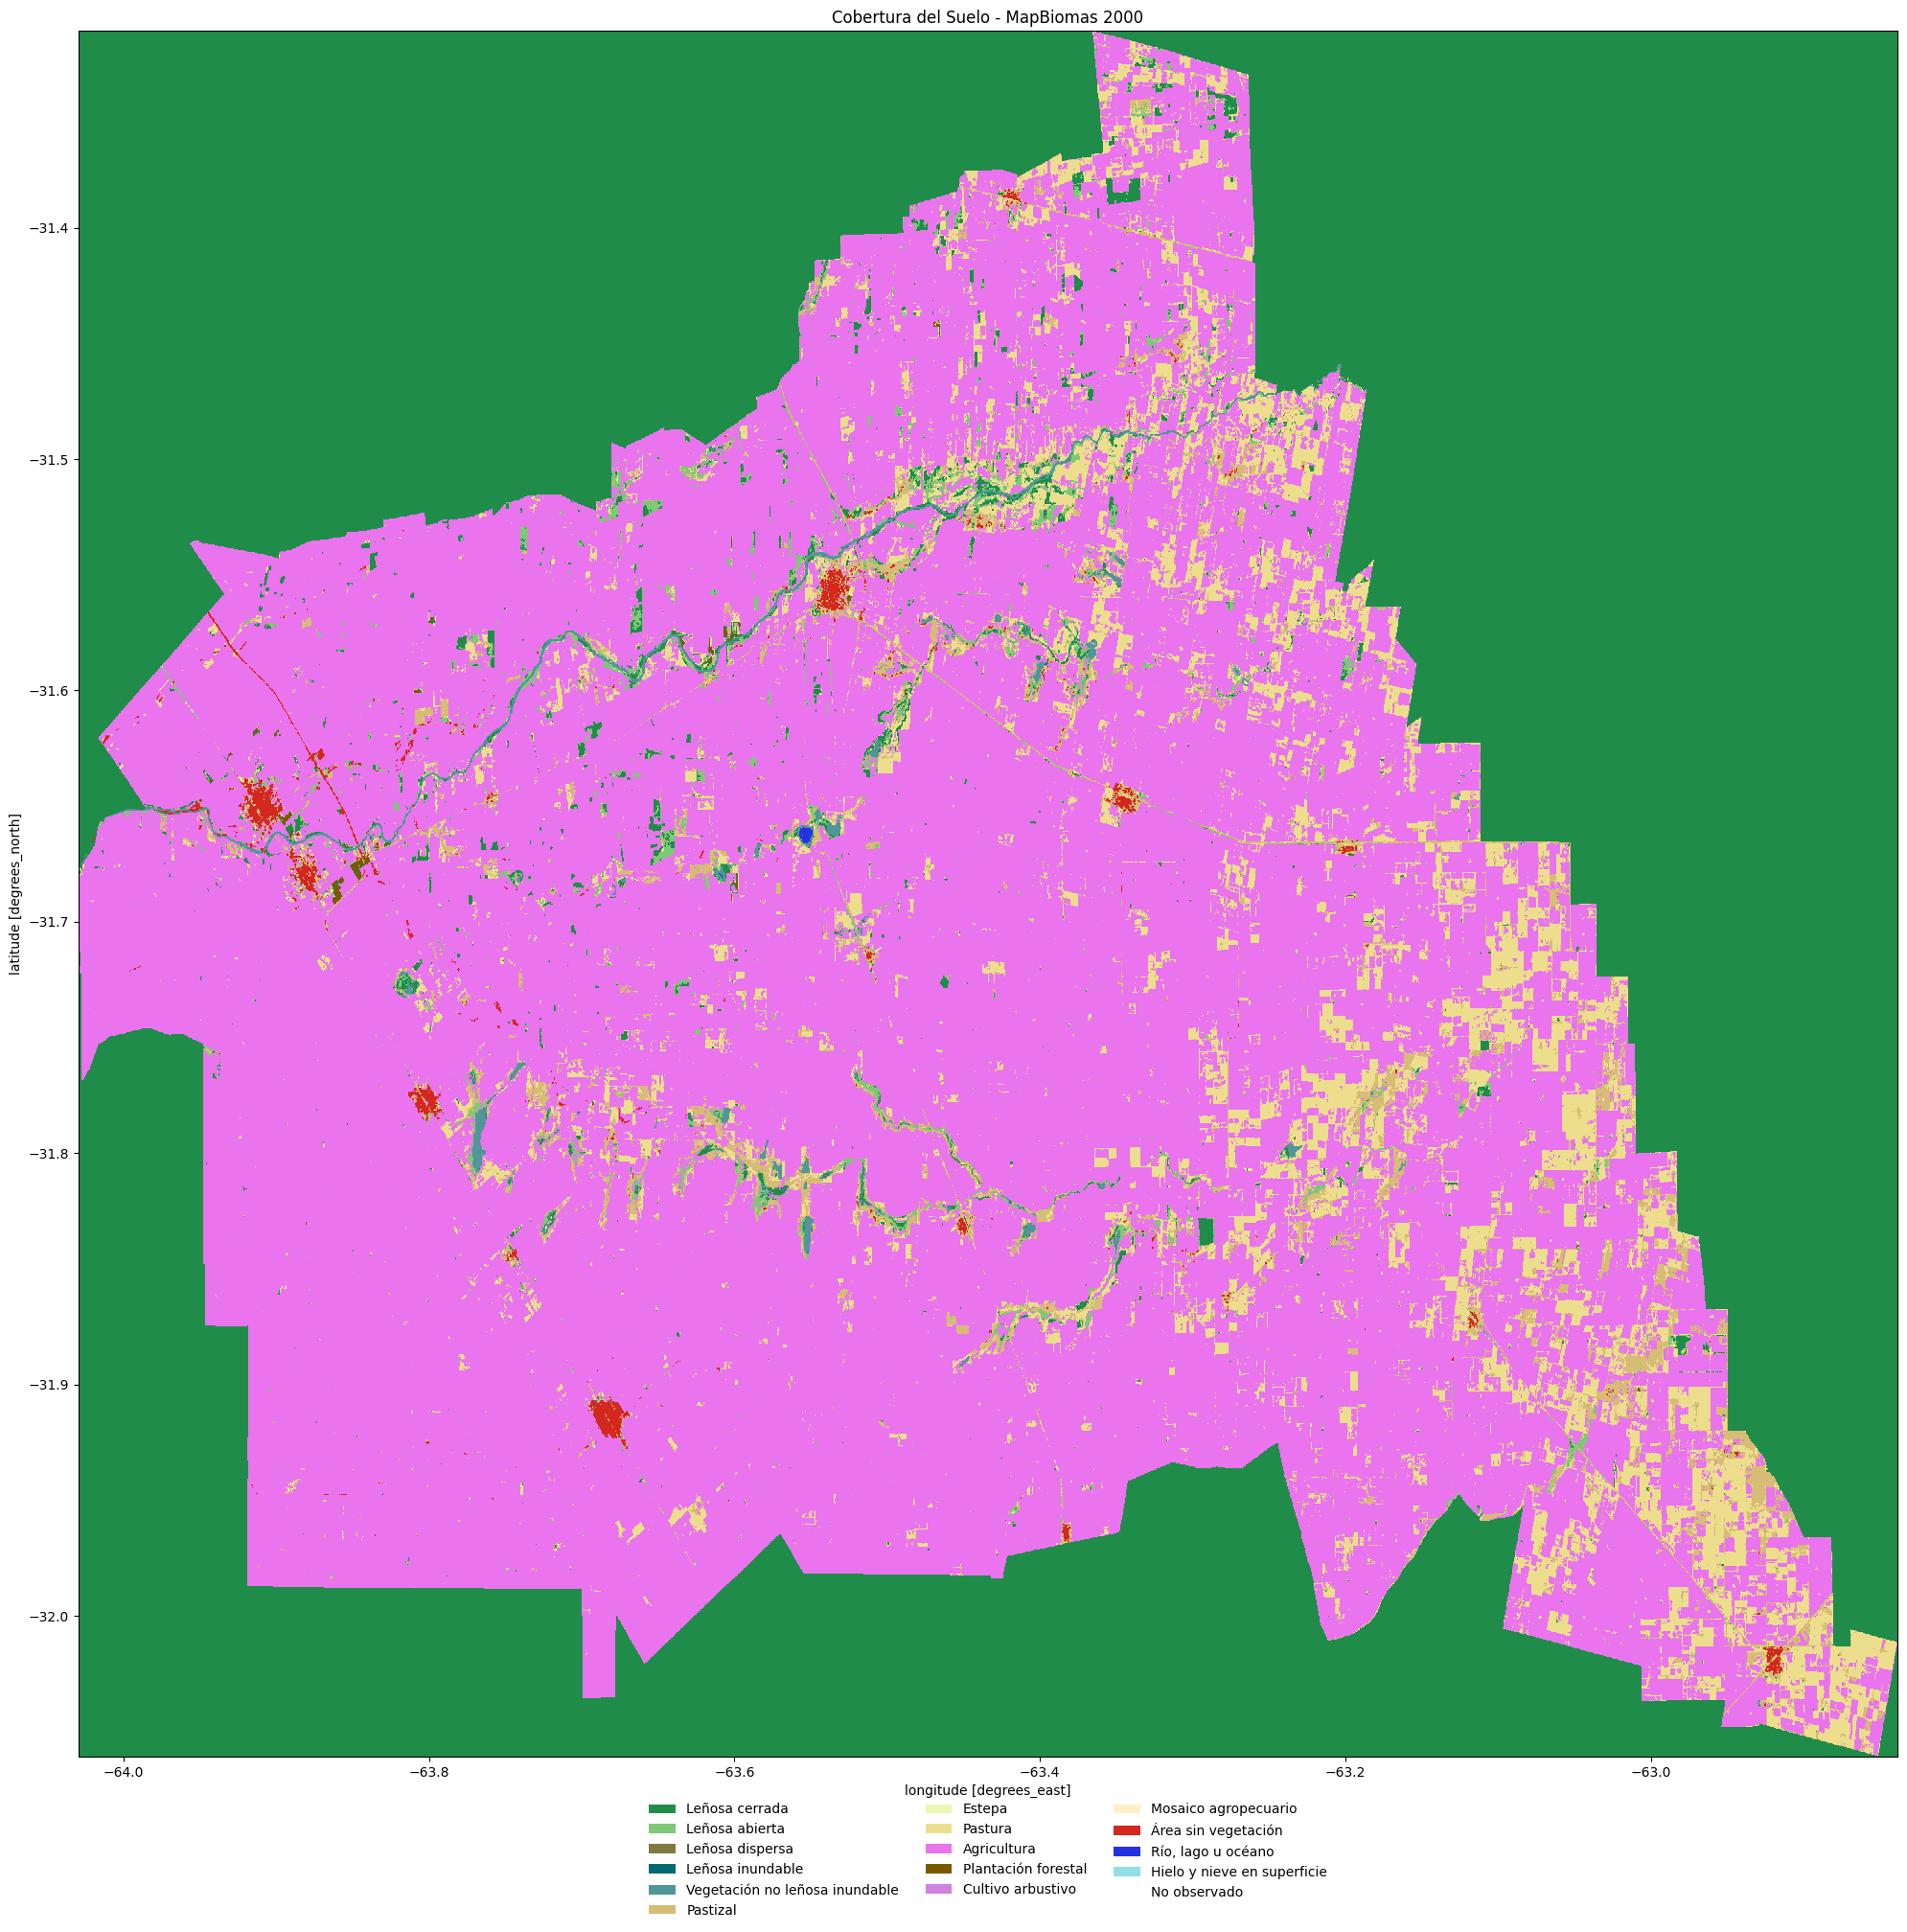

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        colors[pixel_id] = info['color']

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2000.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info['color']] = category

# Add legend below the map
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=label) 
                  for color, label in legend_labels.items()]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
          ncol=3, frameon=False)

plt.title('Cobertura del Suelo - MapBiomas 2000')
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd
import numpy as np

# Calculate pixel counts for each category
unique_values, counts = np.unique(suelo_2000.values[0], return_counts=True)

# Create a mapping from pixel IDs to category names
id_to_category = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        id_to_category[pixel_id] = category

# Calculate total pixels and area per pixel (assuming 100m resolution)
total_pixels = np.sum(counts)
pixel_area_hectares = 0.01  # 100m x 100m = 1 hectare

# Create results list
results = []
for pixel_id, count in zip(unique_values, counts):
    if pixel_id in id_to_category:
        category = id_to_category[pixel_id]
        area_hectares = count * pixel_area_hectares
        percentage = (count / total_pixels) * 100
        results.append({
            'Categoría': category,
            'ID': pixel_id,
            'Área (hectáreas)': f"{area_hectares:,.1f}",
            'Porcentaje (%)': f"{percentage:.1f}"
        })

# Sort by area (descending)
results.sort(key=lambda x: float(x['Área (hectáreas)'].replace(',', '')), reverse=True)

# Create DataFrame and display
df = pd.DataFrame(results)
print("Cobertura del Suelo - MapBiomas 2000")
print("=" * 50)
print(df.to_string(index=False))
print(f"\nTotal área: {total_pixels * pixel_area_hectares:,.1f} hectáreas")

Cobertura del Suelo - MapBiomas 2000
                     Categoría  ID Área (hectáreas) Porcentaje (%)
                   Agricultura  18         57,112.6           46.7
                       Pastura  15          6,247.9            5.1
                      Pastizal  12          2,029.9            1.7
                Leñosa abierta   4            814.3            0.7
                Leñosa cerrada   3            646.5            0.5
           Área sin vegetación  22            309.7            0.3
Vegetación no leñosa inundable  11            307.6            0.3
           Plantación forestal   9             34.8            0.0
            Río, lago u océano  33              6.5            0.0
                        Estepa  63              0.3            0.0

Total área: 122,273.7 hectáreas


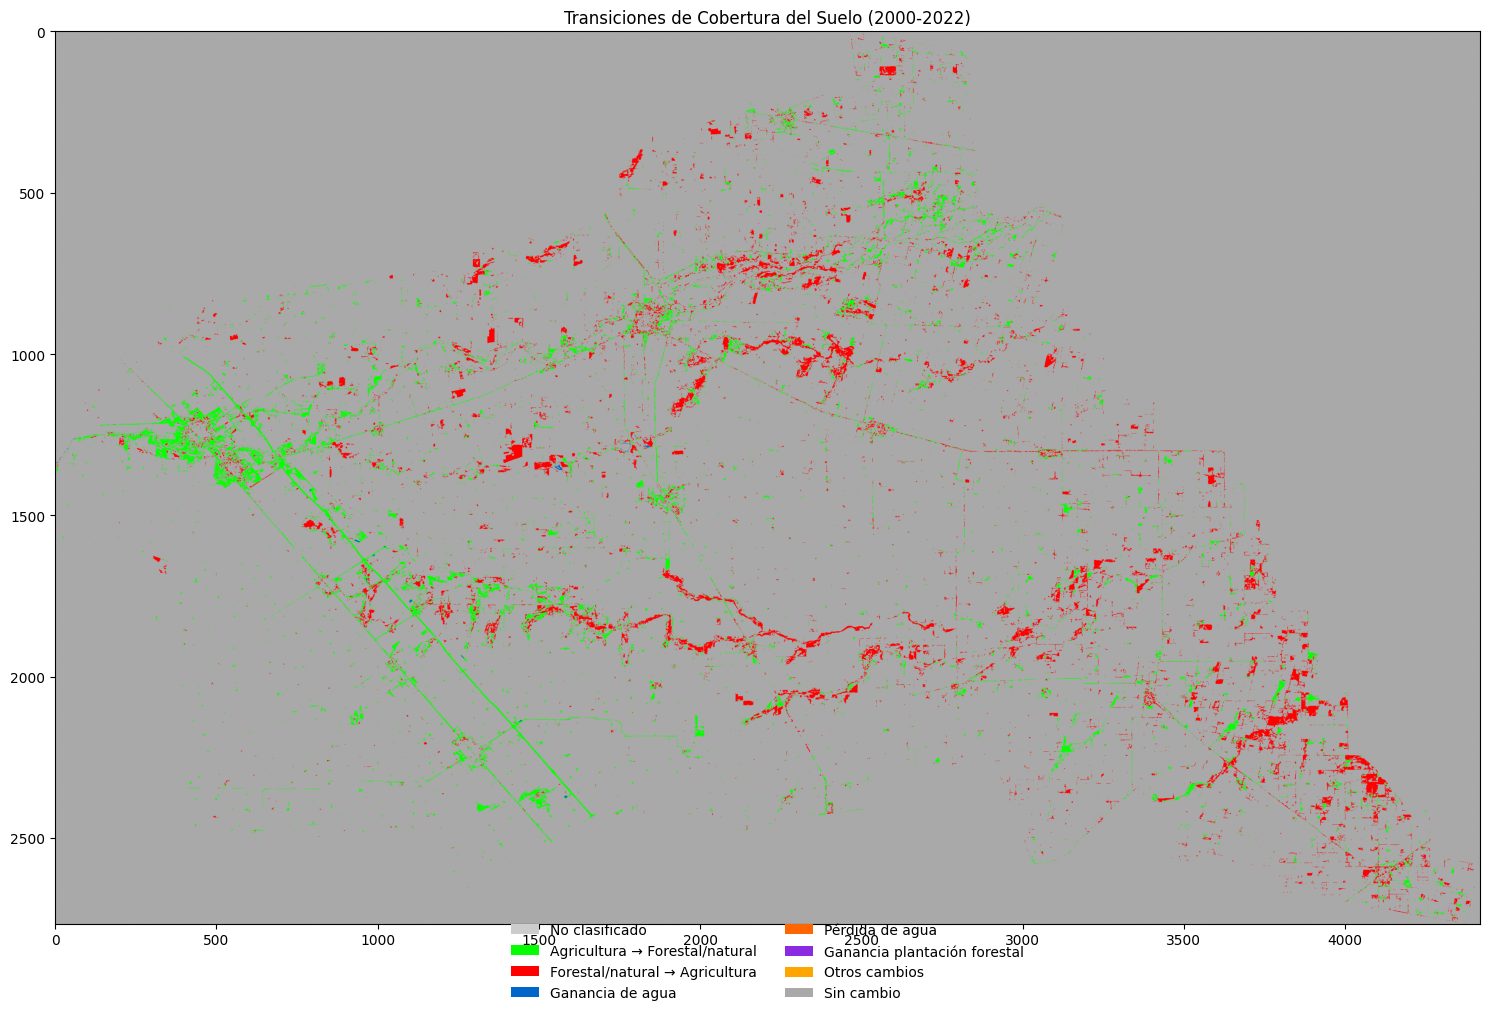

In [54]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

# Get the raw pixel values
suelo_2000_values = suelo_2000.values[0]
suelo_2022_values = suelo_2022.values[0]

# Convert to grouped categories
suelo_2000_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2000_values)
suelo_2022_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2022_values)

# Create transition map
transition_map = np.zeros_like(suelo_2000_cat, dtype=int)

# Only process pixels that actually changed
changed_mask = (suelo_2000_values != suelo_2022_values)

# Transition 1: Agriculture/non-vegetated → Forest/natural (natural regrowth)
mask1 = changed_mask & ((suelo_2000_cat == 'Área agropecuaria') | 
                       (suelo_2000_cat == 'Área sin vegetación')) & \
        ((suelo_2022_cat == 'Vegetación leñosa') | 
         (suelo_2022_cat == 'Vegetación no leñosa'))
transition_map[mask1] = 1

# Transition 2: Forest/natural → Agriculture/non-vegetated
mask2 = changed_mask & ((suelo_2000_cat == 'Vegetación leñosa') | 
                       (suelo_2000_cat == 'Vegetación no leñosa')) & \
        ((suelo_2022_cat == 'Área agropecuaria') | 
         (suelo_2022_cat == 'Área sin vegetación'))
transition_map[mask2] = 2

# Transition 3: Water gain
mask3 = changed_mask & (suelo_2000_cat != 'Cuerpo de agua') & (suelo_2022_cat == 'Cuerpo de agua')
transition_map[mask3] = 3

# Transition 4: Water loss
mask4 = changed_mask & (suelo_2000_cat == 'Cuerpo de agua') & (suelo_2022_cat != 'Cuerpo de agua')
transition_map[mask4] = 4

# Transition 5: Forest plantation gain (only specific plantation types)
mask5 = changed_mask & (suelo_2000_cat == 'Área agropecuaria') & (suelo_2022_cat == 'Vegetación leñosa') & (suelo_2022_values == 9)
transition_map[mask5] = 5

# Transition 6: Other changes (catch-all for remaining changed pixels)
mask6 = changed_mask & (transition_map == 0)
transition_map[mask6] = 6

# Transition 7: No change
transition_map[~changed_mask] = 7

# Colors
colors = {
    0: '#cccccc',  # Unclassified
    1: '#06ff00',  # Agriculture → Forest/natural (regeneration)
    2: '#ff0000',  # Forest/natural → Agriculture
    3: '#0066cc',  # Water gain
    4: '#ff6600',  # Water loss
    5: '#8a2be2',  # Forest plantation gain
    6: '#ffa500',  # Other changes
    7: '#aaa9a9'   # No change
}

labels = {
    0: 'No clasificado',
    1: 'Agricultura → Forestal/natural',
    2: 'Forestal/natural → Agricultura',
    3: 'Ganancia de agua',
    4: 'Pérdida de agua',
    5: 'Ganancia plantación forestal',
    6: 'Otros cambios',
    7: 'Sin cambio'
}

# Create colormap
cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(transition_map, cmap=cmap, norm=norm)

# Legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], label=labels[i]) 
                  for i in sorted(colors.keys())]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
          ncol=2, frameon=False)

plt.title('Transiciones de Cobertura del Suelo (2000-2022)')
plt.tight_layout()
plt.show()

In [39]:
import plotly.graph_objects as go
import numpy as np

def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

# Convert pixel values to grouped categories
suelo_2000_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2000.values[0])
suelo_2022_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2022.values[0])

# Calculate pixel counts for each category
unique_2000, counts_2000 = np.unique(suelo_2000_cat, return_counts=True)
unique_2022, counts_2022 = np.unique(suelo_2022_cat, return_counts=True)

# Filter out 'Other' and get only categories that exist
existing_2000 = unique_2000[unique_2000 != 'Other']
existing_2022 = unique_2022[unique_2022 != 'Other']

# Calculate total pixels
total_2000 = sum(counts_2000[unique_2000 != 'Other'])
total_2022 = sum(counts_2022[unique_2022 != 'Other'])

# Create transition matrix
transition_matrix = {}
for cat_2000 in existing_2000:
    transition_matrix[cat_2000] = {}
    mask_2000 = (suelo_2000_cat == cat_2000)
    for cat_2022 in existing_2022:
        mask_2022 = (suelo_2022_cat == cat_2022)
        transition_count = np.sum(mask_2000 & mask_2022)
        if transition_count > 0:
            transition_matrix[cat_2000][cat_2022] = transition_count

# Prepare data for Sankey diagram
source = []
target = []
value = []
node_labels = []
node_colors = []

# Add 2000 categories
for cat in existing_2000:
    count = counts_2000[unique_2000 == cat][0]
    percentage = (count / total_2000) * 100
    node_labels.append(f"{cat}<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]['color'])

# Add 2022 categories
for cat in existing_2022:
    count = counts_2022[unique_2022 == cat][0]
    percentage = (count / total_2022) * 100
    node_labels.append(f"{cat}<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]['color'])

# Create links
link_colors = []
for cat_2000, transitions in transition_matrix.items():
    for cat_2022, count in transitions.items():
        source_idx = node_labels.index(f"{cat_2000}<br>({(counts_2000[unique_2000 == cat_2000][0] / total_2000) * 100:.1f}%)")
        target_idx = node_labels.index(f"{cat_2022}<br>({(counts_2022[unique_2022 == cat_2022][0] / total_2022) * 100:.1f}%)")
        
        source.append(source_idx)
        target.append(target_idx)
        value.append(count)
        link_colors.append(categories_grouped[cat_2000]['color'])

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Transiciones de Cobertura del Suelo (2000-2022)",
    font_size=12,
    width=1000,
    height=600
)

fig.show()